/var/folders/20/ybnfwpmd59s4m0gwcvjlxplr0000gn/T/ipykernel_23544/2773599227.py:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (class_label, count) in enumerate(class_counts.iteritems()):


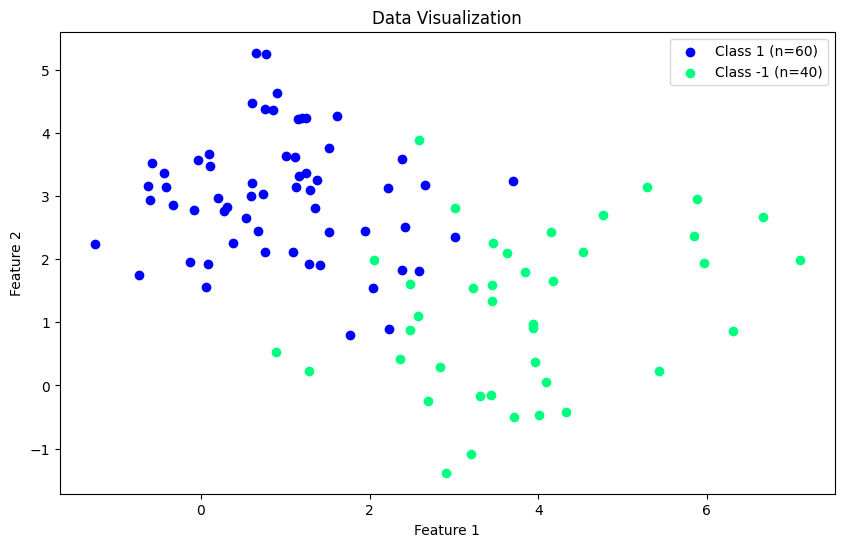

In [16]:
#Project 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("/Users/dannilin/Desktop/PR/Project2/Proj2DataSet.xlsx", header=None, names=["feature1", "feature2", "label"])


# Count instances of each class
class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))

colors = plt.cm.winter(np.linspace(0, 1, len(class_counts)))  # Generate colors

# Plot each class separately to have individual labels
for i, (class_label, count) in enumerate(class_counts.iteritems()):
    # Select rows where the class label matches
    class_data = df[df['label'] == class_label]
    
    plt.scatter(class_data['feature1'], class_data['feature2'], color=colors[i], label=f'Class {class_label} (n={count})')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Visualization')
plt.legend()
plt.show()


In [2]:
df.describe()

,feature1,feature2,label
count,100.000000,100.000000,100.000000
mean,2.091025,2.274225,0.200000
std,1.854014,1.410063,0.984732
min,-1.255823,-1.383075,-1.000000
25%,0.722228,1.558772,-1.000000
50%,1.690487,2.426026,1.000000
75%,3.442606,3.182743,1.000000
max,7.098152,5.269215,1.000000


In [3]:
# Calculate variance of features
variance_values = df.var()
print("\nVariance Values:\n", variance_values)


Variance Values:
 feature1    3.437369
feature2    1.988277
label       0.969697
dtype: float64


In [4]:
# Calculate variance for each column for each species
variance_df = df.groupby('label').var()

print(variance_df)

       feature1  feature2
label                    
-1     1.978200  1.581348
 1     1.037358  0.941975


In [5]:
# Within-Class Variance

sw_1 = (40/100)*1.978200 + (60/100)*1.037358
sw_2 = (40/100)*1.581348 + (60/100)*0.941975

print('Within-Class Variance')
print('Feature 1: ', np.round(sw_1,2)) 
print('Feature 2: ',np.round(sw_2,2)) 

Within-Class Variance
Feature 1:  1.41
Feature 2:  1.2


In [6]:
# Count the occurrences of each species
species_counts = df['label'].value_counts()

print(species_counts)

 1    60
-1    40
Name: label, dtype: int64


In [7]:
# Calculate variance for each column for each species
mean_df = df.groupby('label').mean()

print(mean_df)

       feature1  feature2
label                    
-1     3.831480  1.181589
 1     0.930722  3.002650


In [8]:
# Between-Class Variance

sb_1 = (40/100)*(3.83148-2.10)**2 + (60/100)*(0.930722-2.10)**2
sb_2 = (40/100)*(1.181589-2.27)**2 + (60/100)*(3.002650-2.27)**2 

print('Between-Class Variance')
print('Feature 1: ', np.round(sb_1,2)) 
print('Feature 2: ',np.round(sb_2,2)) 

Between-Class Variance
Feature 1:  2.02
Feature 2:  0.8


## Soft SVM

In [9]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def solve_dual_svm_problem(X, y, C):

    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = linear_kernel(X[i], X[j])
    
    P = matrix(np.outer(y,y) * K) #matrix of quadratic terms of alpha
    q = matrix(np.ones(n_samples) * -1) #linear terms of alpha

    #A and b matrices refers to the equality constraint: sum of alpha_i * y_i = 0
    A = matrix(y, (1,n_samples), 'd') 
    b = matrix(0.0) 

    #G and h matrices refers to the inequality constraint: 0 <= alpha_i <= C
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    
    # Solve QP problem
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])
    
    return alphas

def custom_sign(values):
    """
    Returns 1 for non-negative values and -1 for negative values.
    This adjusts the standard np.sign behavior to treat 0 as 1.
    """
    return np.where(values > 0, 1, -1)

# Function to count misclassified samples
def count_misclassified_samples(X, y, w, b):
    decisions = np.dot(X, w) + b
    predictions = custom_sign(decisions)
    misclassified = np.sum(predictions != y)
    return misclassified

def plot_decision_boundary(X, y, alphas, C):
    
    # Filter out non-zero alphas to find support vectors
    sv = alphas > 1e-3
    ind = np.arange(len(alphas))[sv]
    alphas_sv = alphas[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    
    # Compute weight vector and bias
    w = np.dot(sv_x.T, alphas_sv * sv_y)
    b = np.mean(sv_y - np.dot(sv_x, w))
    
    # Plot data points and support vectors
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')
    plt.scatter(sv_x[:, 0], sv_x[:, 1], s=100, facecolors='none', edgecolors='k', label=f'Support Vectors: {len(sv_x)}')
  
    
    # Plot decision boundary and margins
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')

    # Identify and plot misclassified samples
    decisions = np.dot(X, w) + b
    predictions = custom_sign(decisions)
    misclassified_indices = np.where(predictions != y)[0]
    misclassified_count = count_misclassified_samples(X, y, w, b)
    plt.scatter(X[misclassified_indices, 0], X[misclassified_indices, 1], s=50, c='red', marker='x', label=f'Misclassified Samples: {misclassified_count}')

    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'SVM Decision Boundary with C={C}')
    plt.legend()
    plt.show()
    
    misclassified_count = count_misclassified_samples(X, y, w, b)
    print(f'Number of Misclassified Samples: {misclassified_count}')
    print(f'Number of Support Vectors: {len(sv_x)}')

In [10]:
# Load the dataset
df = pd.read_excel("/Users/dannilin/Desktop/PR/Project2/Proj2DataSet.xlsx", engine='openpyxl')

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

#print(X)
#print(y)

     pcost       dcost       gap    pres   dres
 0: -1.5413e+01 -1.8503e+01  6e+02  2e+01  2e-14
 1: -2.6198e+00 -1.7067e+01  3e+01  8e-01  2e-14
 2: -1.8457e+00 -5.8577e+00  4e+00  3e-02  5e-15
 3: -2.1331e+00 -2.8487e+00  8e-01  5e-03  4e-15
 4: -2.3031e+00 -2.4911e+00  2e-01  1e-03  5e-15
 5: -2.3558e+00 -2.3989e+00  4e-02  2e-04  5e-15
 6: -2.3713e+00 -2.3731e+00  2e-03  2e-06  4e-15
 7: -2.3722e+00 -2.3722e+00  7e-05  4e-08  5e-15
 8: -2.3722e+00 -2.3722e+00  6e-06  3e-09  3e-15
 9: -2.3722e+00 -2.3722e+00  2e-07  3e-11  4e-15
Optimal solution found.


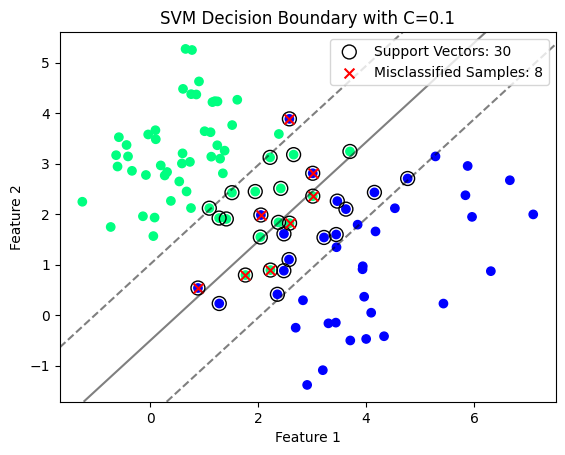

Number of Misclassified Samples: 8
Number of Support Vectors: 30
     pcost       dcost       gap    pres   dres
 0: -5.5041e+02 -4.1761e+05  8e+05  4e-01  2e-12
 1:  6.7718e+02 -5.7149e+04  7e+04  2e-02  2e-12
 2: -9.1204e+02 -9.5769e+03  9e+03  1e-03  2e-12
 3: -1.1914e+03 -3.5751e+03  2e+03  3e-04  2e-12
 4: -1.3207e+03 -2.9370e+03  2e+03  2e-04  2e-12
 5: -1.5046e+03 -2.3470e+03  8e+02  7e-05  2e-12
 6: -1.5460e+03 -2.0266e+03  5e+02  2e-05  2e-12
 7: -1.6286e+03 -1.9169e+03  3e+02  7e-06  3e-12
 8: -1.6178e+03 -1.8537e+03  2e+02  3e-06  2e-12
 9: -1.6580e+03 -1.8084e+03  2e+02  1e-06  3e-12
10: -1.7119e+03 -1.7285e+03  2e+01  8e-08  3e-12
11: -1.7175e+03 -1.7191e+03  2e+00  5e-09  3e-12
12: -1.7182e+03 -1.7182e+03  2e-02  5e-11  3e-12
13: -1.7182e+03 -1.7182e+03  2e-04  5e-13  3e-12
Optimal solution found.


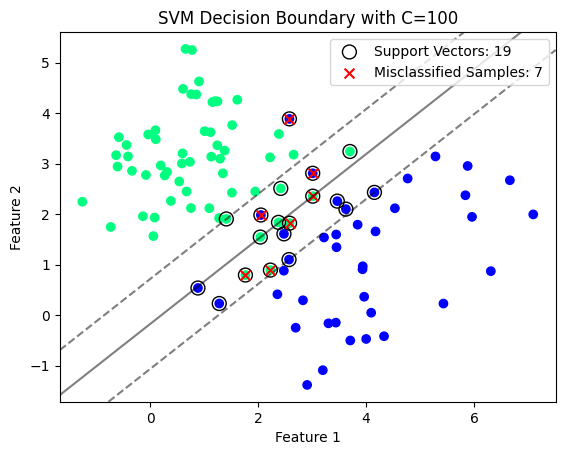

Number of Misclassified Samples: 7
Number of Support Vectors: 19


In [11]:
# Example usage
C_values = [0.1, 100]

for C in C_values:
    alphas = solve_dual_svm_problem(X, y, C)
    plot_decision_boundary(X, y, alphas, C)

## SMO Vs. SVM implementation

     pcost       dcost       gap    pres   dres
 0: -3.9954e+01 -3.8806e+01  1e+03  2e+01  4e-14
 1: -7.6116e+00 -3.6042e+01  1e+02  2e+00  4e-14
 2: -4.8962e+00 -1.9572e+01  2e+01  2e-01  7e-15
 3: -4.3719e+00 -6.7660e+00  3e+00  2e-02  8e-15
 4: -4.7552e+00 -5.5991e+00  1e+00  6e-03  5e-15
 5: -4.9185e+00 -5.2285e+00  3e-01  2e-03  4e-15
 6: -4.9743e+00 -5.1234e+00  2e-01  8e-04  5e-15
 7: -5.0068e+00 -5.0613e+00  6e-02  2e-04  5e-15
 8: -5.0227e+00 -5.0366e+00  1e-02  3e-05  6e-15
 9: -5.0287e+00 -5.0291e+00  4e-04  7e-07  5e-15
10: -5.0288e+00 -5.0289e+00  4e-06  7e-09  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.1771e+01 -7.7964e+01  3e+03  2e+01  7e-14
 1: -1.3607e+01 -7.2241e+01  2e+02  2e+00  7e-14
 2: -8.4619e+00 -3.8723e+01  5e+01  2e-01  2e-14
 3: -7.0299e+00 -1.2783e+01  8e+00  3e-02  1e-14
 4: -7.6139e+00 -8.9550e+00  2e+00  6e-03  8e-15
 5: -7.7874e+00 -8.4472e+00  8e-01  2e-03  9e-15
 6: -7.8863e+00 -8.2150e+00  4e-01  1e-03  8e-1

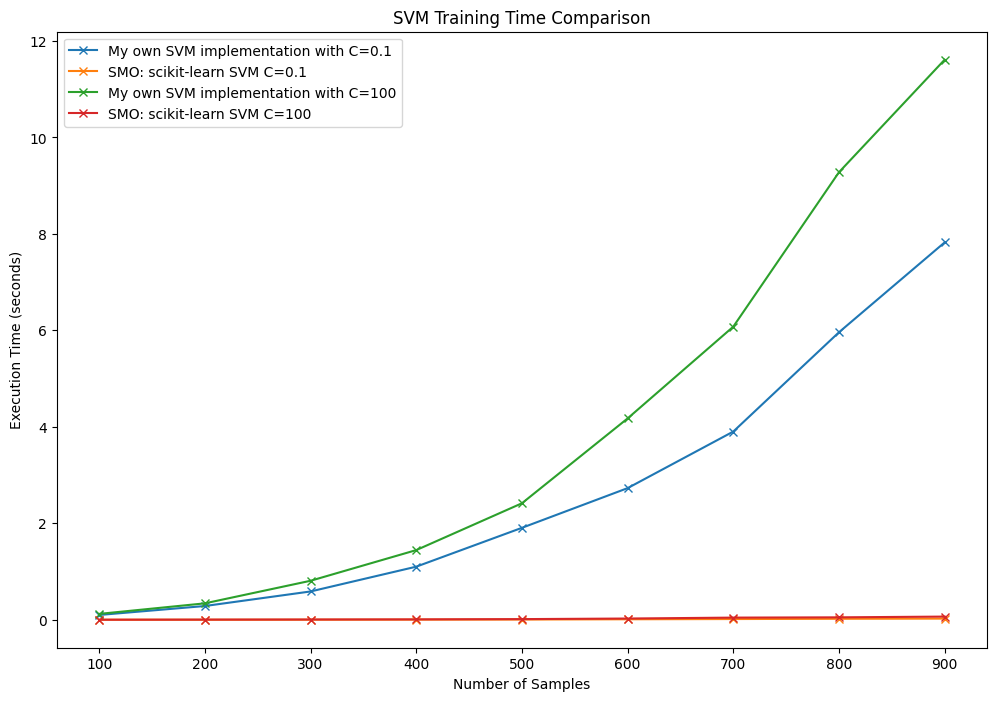

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd 


def run_timing():
    np.random.seed(100)

    time_my_model_c_01 = []
    time_sklearn_c_01 = []
    time_my_model_c_100 = []
    time_sklearn_c_100 = []

    for c in [0.1, 100]:
        for i in range(100, 1000, 100):
            
            # Generate synthetic data
            class1 = np.random.multivariate_normal([1, 3], [[1, 0], [0, 1]], i)
            class2 = np.random.multivariate_normal([4, 1], [[2, 0], [0, 2]], i)
            X_train, y_train = np.vstack((class1, class2)), np.hstack((np.ones(i), -np.ones(i)))

            # Time scikit-learn SVM
            start = time.time()
            clf_sklearn = make_pipeline(StandardScaler(), SVC(gamma='auto', C=c))
            clf_sklearn.fit(X_train, y_train)
            end = time.time()
            sklearn_duration = end - start
            if c == 0.1:
                time_sklearn_c_01.append(sklearn_duration)
            else:
                time_sklearn_c_100.append(sklearn_duration)

            # Time custom solve_dual_svm_problem
            start = time.time()
            alphas = solve_dual_svm_problem(X_train, y_train, C=c)  # This replaces the SVM class
            end = time.time()
            custom_duration = end - start
            if c == 0.1:
                time_my_model_c_01.append(custom_duration)
            else:
                time_my_model_c_100.append(custom_duration)

    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.plot(range(100, 1000, 100), time_my_model_c_01, '-x', label='My own SVM implementation with C=0.1')
    plt.plot(range(100, 1000, 100), time_sklearn_c_01, '-x', label='SMO: scikit-learn SVM C=0.1')
    plt.plot(range(100, 1000, 100), time_my_model_c_100, '-x', label='My own SVM implementation with C=100')
    plt.plot(range(100, 1000, 100), time_sklearn_c_100, '-x', label='SMO: scikit-learn SVM C=100')
    plt.xlabel('Number of Samples')
    plt.ylabel('Execution Time (seconds)')
    plt.title('SVM Training Time Comparison')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    run_timing()